# Transfer learning

Set the environment blah blah:

In [1]:
#|code-fold: true
#|output: false
!pip install numpy pandas matplotlib torchviz scikit-learn tensorboard torchvision torch tqdm torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=14150ed275b71cc321e0addaa2f7103b464ab9c581c642151b97b660dc737a5a
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


If this is GoogleColab we download config and use it to download necesseary folders and files for this project (defined in `config.py`). Here we'll need:
- `pytorched.step_by_step.py`
- `data_preparation.rps.py`

In [2]:
#|code-fold: true
#|output: false
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/nesaboz/pytorched/main/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    print('Not GoogleColab.')
    pass

from config import config_project
config_project('transfer_learning')

Finished!


We are now ready for imports:

In [3]:
#|code-fold: true
#|output: false
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop, InterpolationMode
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
from torchvision.models.alexnet import model_urls
from torchvision.models import Inception_V3_Weights, AlexNet_Weights
from torch.hub import load_state_dict_from_url
from torchviz import make_dot

from data_generation.rps import download_rps
from pytorched.step_by_step import StepByStep

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

# AlexNet

Let's try to use AlexNet model first to help us in the Rock-Paper-Scissors problem. We'll need to load AlexNet, with it's weights, then make a feature-extractor on our data loaders, modify the last layer, and train. Let's get to it: 

We can get AlexNet from torchvision.models:

In [4]:
weights = AlexNet_Weights.IMAGENET1K_V1
alex = alexnet(weights=weights)
alex

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We need an original transform:

In [5]:
transform = weights.transforms()

Let's now create new data loaders based on this transform:


In [5]:
#|code-fold: true 
#|output: false
download_rps()

In [7]:
train_dataset = ImageFolder(root='rps', transform=transform)
val_dataset = ImageFolder(root='rps-test-set', transform=transform)

In [8]:
train_loader = DataLoader(train_dataset, 16, shuffle=True)
val_loader = DataLoader(val_dataset, 16)

Let's also define an optimizer and loss:

In [9]:
torch.manual_seed(17)
optimizer = optim.Adam(alex.parameters(), 3e-4)
loss_fn = nn.CrossEntropyLoss()
sbs = StepByStep(alex, optimizer, loss_fn)
sbs.set_loaders(train_loader, val_loader)

# Feature-extractor


These are current trainable parameters:

In [10]:
sbs.print_trainable_parameters()

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


We must freeze the model and replace the last layer. These are suggestions what layers to change (of course more layers can be left unfrozen but this requires more training data and longer times):

![image-2.png](attachment:image-2.png)

so let's change the last layer first to Identity to make feature extractor:

In [11]:
sbs.model.classifier[6] = nn.Identity()

In [12]:
sbs.freeze_model()

In [13]:
sbs.print_trainable_parameters()

No trainable parameters.


We now go throught the loader batch by batch and pass the data through the model in order to generate new preprocessed datasets: 

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
def preprocessed_dataset(model, loader, device=None):
    """
    Runs all data in the loader through the model and returns a dataset.
    """
    
    features = torch.Tensor()
    labels = torch.Tensor().type(torch.long)

    if device is None:
        device = next(model.parameters()).device

    for i, (x_batch, y_batch) in enumerate(loader):
        model.eval()
        output = model(x_batch.to(device))
        features = torch.cat([features, output.detach().cpu()])
        labels = torch.cat([labels, y_batch.cpu()])

    return TensorDataset(features, labels)

In [16]:
def test_preprocessed_dataset():
    x = torch.rand(10,3,244,244)
    y = torch.rand(10,1)
    ds = TensorDataset(x,y)
    dl = DataLoader(ds, 16, False)
    tpp = preprocessed_dataset(alex, dl)
    assert tpp.tensors[0].shape == torch.Size([10, 4096])

In [17]:
train_preproc = preprocessed_dataset(alex, train_loader)
val_preproc = preprocessed_dataset(alex, val_loader)

make sure that the tensort types are correct:

In [18]:
assert next(iter(train_preproc))[0].type() == 'torch.FloatTensor'
assert next(iter(train_preproc))[1].type() == 'torch.LongTensor' 

we now build new DataLoaders:

In [19]:
new_train_loader = DataLoader(train_preproc, 16, True)
new_val_loader = DataLoader(val_preproc, 16)

# Top layer is new model

Instead of modifing the `sbs.model` we can now create a brand new simple model using a fully-connected layer per table suggestions `nn.Linear(4096, num_classes)`:

Let's create a new model:

In [59]:
torch.manual_seed(17)
top_layer = nn.Linear(4096, 3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(top_layer.parameters(), lr=3e-4)
sbs_top = StepByStep(top_layer, optimizer_top, multi_loss_fn)
sbs_top.set_loaders(new_train_loader, new_val_loader)

initializing


In [60]:
next(sbs_top.model.parameters()).is_cuda

True

In [61]:
sbs_top.train(10)

100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


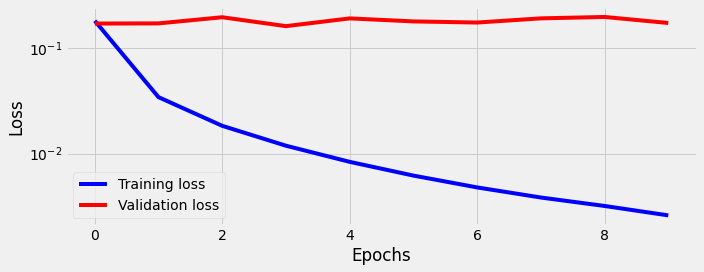

In [62]:
_ = sbs_top.plot_losses()

In [63]:
sbs_top.accuracy

95.97

In [64]:
sbs_top.accuracy_per_class

tensor([[109, 124],
        [124, 124],
        [124, 124]])

And this is pretty good, and very fast too!

For any new images that need to be evaluated thought, we will have to go through the whole model, so let's insert this new `top_layer` into a `sbs`:

In [65]:
sbs.model.classifier[6] = top_layer
sbs.model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

Let's evaluate on the old `val_loader` to see if we get the same result:

In [66]:
sbs.accuracy_per_class

tensor([[109, 124],
        [124, 124],
        [124, 124]])

In [67]:
sbs.accuracy

95.97

yup, exactly the same.

# Inception Model

Let's try Inception model. Inception has these 2 layers so we can not run the feature extraction, we have to use the full model. First we prep the data:

In [6]:
weights = Inception_V3_Weights.IMAGENET1K_V1
transform = weights.transforms()
train_dataset = ImageFolder(root='rps', transform=transform)
val_dataset = ImageFolder(root='rps-test-set', transform=transform)
train_loader = DataLoader(train_dataset, 16, True)
val_loader = DataLoader(val_dataset, 16)

In [7]:
transform

ImageClassification(
    crop_size=[299]
    resize_size=[342]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

next we set the model

In [8]:
inception = inception_v3(weights=weights)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

replace the top layers:

In [9]:
def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

In [10]:
freeze_model(inception)

In [11]:
inception.fc = nn.Identity()
inception.AuxLogits.fc = nn.Identity()

create special loss function that combines losses from 2 output layers:

In [12]:
def inception_loss(outputs, labels):
    try:
        main, aux = outputs
    except ValueError:
        main = outputs
        aux = None
        
    multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
    loss_main = multi_loss_fn(main, labels)
    loss_aux = multi_loss_fn(aux, labels) if aux is not None else 0
    return loss_main + 0.4 * loss_aux

In [13]:
torch.manual_seed(17)
optimizer = optim.Adam(inception.parameters(), lr=3e-4)

In [14]:
sbs_inception = StepByStep(inception, optimizer, inception_loss)
sbs_inception.set_loaders(train_loader, val_loader)

In [34]:
len(sbs_inception.optimizer.state_dict()['param_groups'][0]['params'])

292

In [31]:
len(list(inception.parameters()))

292

In [33]:
sbs_inception.optimizer = optim.Adam(inception.parameters(), lr=3e-4)

In [18]:
inception.fc = nn.Linear(2048, 3)
inception.AuxLogits.fc = nn.Linear(768, 3)
sbs_inception.to(sbs_inception.device)

In [20]:
sbs_inception.print_trainable_parameters()

AuxLogits.fc.weight
AuxLogits.fc.bias
fc.weight
fc.bias


so we created new datasets with transform from inception, created new loss that handles 2 outputs (one main and one auxilary), we then froze the model and replaced the top layers. We just need to train now:

In [41]:
sbs_inception.train(4)

100%|██████████| 4/4 [02:06<00:00, 31.60s/it]


In [42]:
sbs_inception.accuracy_per_class

tensor([[ 99, 124],
        [112, 124],
        [121, 124]])

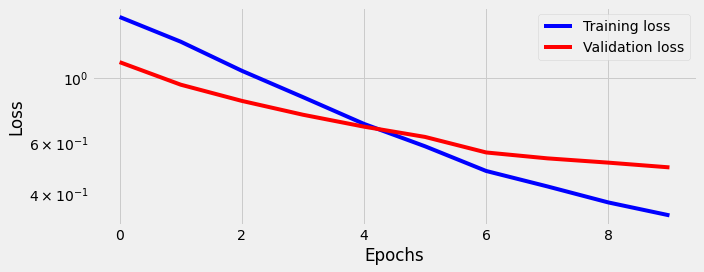

In [43]:
sbs_inception.plot_losses()

In [44]:
sbs_inception.accuracy

89.25

# Batch normalization

In [133]:
model = inception_v3(weights='DEFAULT')

In [134]:
freeze_model(model)

In [135]:
weights = Inception_V3_Weights.IMAGENET1K_V1
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[299]
    resize_size=[342]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [136]:
torch.manual_seed(42)
model.AuxLogits.fc = nn.Linear(768, 3)
model.fc = nn.Linear(2048, 3)

In [147]:
def inception_loss(outputs, labels):
    try:
        main, aux = outputs
    except ValueError:
        main = outputs
        aux = None
        
    multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
    loss_main = multi_loss_fn(main, labels)
    loss_aux = multi_loss_fn(aux, labels) if aux is not None else 0
    return loss_main + 0.4 * loss_aux

In [148]:
optimizer_model = optim.Adam(model.parameters(), lr=3e-4)
sbs_incep = StepByStep(model, optimizer_model, inception_loss)

In [149]:
transform

ImageClassification(
    crop_size=[299]
    resize_size=[342]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [150]:
train_data = ImageFolder(root='rps', transform=transform)
val_data = ImageFolder(root='rps-test-set', transform=transform)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [151]:
sbs_incep.set_loaders(train_loader, val_loader)
sbs_incep.train(1)

100%|██████████| 1/1 [00:30<00:00, 30.97s/it]


In [152]:
StepByStep.loader_apply(val_loader, sbs_incep.correct)

tensor([[110, 124],
        [ 96, 124],
        [120, 124]])